##Importación de librerías

In [ ]:
import numpy as np
import openpyxl
import torch #Pytorch , TensorFlow
from torch import nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split
import matplotlib.pyplot as plt
import math
from tabulate import tabulate

##Obteniendo datos a partir de Excel





Asegurarse de tener los siguientes archivos:


1.   datos_experimentales.xlsx
2.   coordenadas_cuadriculas.txt
3.   distancias_clasico.txt



In [ ]:
ruta_del_archivo = "datos_experimentales.xlsx"

# Cargando el libro de Excel
basedatos = openpyxl.load_workbook(ruta_del_archivo)

# Lista de los nombres de todas las hojas
mediciones = basedatos.sheetnames

# Lista para almacenar los datos en el formato deseado
datos_por_hoja = []
max_valores_promedio = 50  # utiliza los primeros 50 valores para calcular el promedio

# Iterando a través de cada hoja de medición
for idx, hoja in enumerate(mediciones, start=1):
    # Cargando la hoja actual
    basedatos_sheet = basedatos[hoja]

    # Diccionario para almacenar los datos de cada ancla
    datos_anclas = {1: [], 2: [], 3: []}

    # Iterando a través de las filas de la hoja
    for fila in basedatos_sheet.iter_rows(min_row=2, values_only=True):
        ancla = fila[0]  # El valor de la columna del ancla
        distancia = fila[1]  # El valor de la columna de distancia

        if distancia is not None:  # Verificar si distancia no es None
            if ancla in datos_anclas:
                datos_anclas[ancla].append(distancia)

    # Calcular los promedios de las distancias a cada ancla
    promedios_por_ancla = {}
    for ancla, distancias in datos_anclas.items():
        if distancias:
            # Calcular valores absolutos de todas las distancias
            # Este paso se hace debido a que los módulos miden valores negativos cuando están muy cerca de algún nodo ancla
            distancias_abs = [abs(d) for d in distancias]
            # Tomar los primeros 50 valores o menos si hay menos de 50
            valores_promedio = distancias_abs[:max_valores_promedio]
            # Calcular el promedio de los valores obtenidos
            promedio_distancias = sum(valores_promedio) / len(valores_promedio)
            promedios_por_ancla[ancla] = round(promedio_distancias, 4)  # Redondear a 4 cifras significativas

    # Verificar si la hoja tiene datos válidos antes de agregar a datos_por_hoja
    if promedios_por_ancla:
        datos_hoja_actual = [idx] + [promedios_por_ancla.get(ancla, 0) for ancla in range(1, 4)]
        datos_por_hoja.append(datos_hoja_actual)


In [ ]:
"""
print(len(datos_por_hoja))
print(datos_por_hoja)
"""

Procesamiento necesario para obtener promedios de las distancias del móvil a las anclas

In [ ]:
# Estos son los promedios de la distancias calculadas con los modulos UWB usando tiempo de vuelo
# Escribiendo los datos en un archivo de texto .txt
distancias_promedios = "datos_promedios.txt" # Estos son los promedios de la distancias calculadas con los modulos UWB usando tiempo de vuelo
with open(distancias_promedios, "w") as archivo_txt:
    archivo_txt.write("N|D1|D2|D3\n") # N es número de medición, D1 es distancia del móvil al ancla 1 y así sucesivamente
    for datos_hoja in datos_por_hoja:
        linea = "|".join(str(valor) for valor in datos_hoja) + "\n"
        archivo_txt.write(linea)


In [ ]:

# Leer el archivo de texto y mostrar las primeras 10 líneas
with open(distancias_promedios, "r") as archivo_txt:
    lineas = archivo_txt.readlines()[:10]

for linea in lineas:
    print(linea.strip())  # strip() para eliminar el salto de línea al final de cada línea

N|D1|D2|D3
1|2.8808|2.9662|1.3328
2|2.6607|2.7921|1.1961
3|2.415|2.7396|1.0127
4|2.2322|2.5293|0.7812
5|2.0243|2.4439|0.9607
6|1.893|2.3384|0.2489
7|1.6391|2.2401|0.0486
8|1.406|2.1714|0.0492
9|1.1908|2.1598|0.291


#Trilateración

##Método Clásico

In [ ]:
#Coordenadas de cada nodo ancla en metros
ancla1 = np.array([2.7, 0])
ancla2 = np.array([2, 2])
ancla3 = np.array([1.3, 0])

In [ ]:
# Definiendo la función de trilateración
def trilateration(ancla1, ancla2, ancla3, distancia1, distancia2, distancia3):
  # Función para calcular la posición del móvil mediante trilateración
  # Considerar que las coordenadas están como arreglo de numpy

  # Calcular las diferencias entre las coordenadas de las anclas
  delta_a2_a1 = ancla2 - ancla1
  delta_a3_a1 = ancla3 - ancla1

  # Calcular las distancias entre las anclas
  d12 = np.linalg.norm(delta_a2_a1)
  d13 = np.linalg.norm(delta_a3_a1)

  # Calcular las coordenadas del móvil
  A = 2 * delta_a2_a1[0]
  B = 2 * delta_a2_a1[1]
  E = distancia1**2 - distancia2**2 - ancla1[0]**2 + ancla2[0]**2 - ancla1[1]**2 + ancla2[1]**2

  C = 2 * delta_a3_a1[0]
  D = 2 * delta_a3_a1[1]
  F = distancia1**2 - distancia3**2 - ancla1[0]**2 + ancla3[0]**2 - ancla1[1]**2 + ancla3[1]**2

  x = (E * D - B * F) / (A * D - B * C)
  y = (A * F - E * C) / (A * D - B * C)

  # Calculando la distancia al origen de coordenadas (0, 0)
  distancia_al_origen = np.linalg.norm([x, y])
  posicion_x = np.array([x])
  posicion_y = np.array([y])


  return posicion_x, posicion_y, distancia_al_origen


In [ ]:
#Función para obtener las mediciones del archivo distancias_promedios.txt
def obtener_mediciones(distancias_promedios):
    datos = []
    with open(distancias_promedios, "r") as archivo_txt:
        # Omitir la primera línea que contiene los nombres de las columnas:
        next(archivo_txt)
        for line in archivo_txt:
            # Separamos los valores de cada fila usando el símbolo "|"
            values = line.strip().split('|')
            # Convertimos los valores numéricos de las distancias a float
            num_values = [float(val) for val in values[1:]]
            datos.append((int(values[0]), num_values)) # Valores colocados en una lista de tuplas
    return datos


En esta sección se calculan las coordenadas y distancia al origen del móvil mediante un método matemático de trilateración

In [ ]:

def calcular_y_guardar_resultados(data, ancla1, ancla2, ancla3):
    with open("generar_resultados_clasico.txt", "w") as archivo_resultados:
        archivo_resultados.write("M|D1|D2|D3|X|Y|D\n")
        for medicion, distancias in data:
            # El asterisco en distancias desempaqueta las variables d1, d2, y d3 de la lista en la tupla "data"
            posicion_x, posicion_y, distancia_al_origen = trilateration(ancla1, ancla2, ancla3, *distancias)
            linea = f"{medicion}|{distancias[0]}|{distancias[1]}|{distancias[2]}|{posicion_x[0]}|{posicion_y[0]}|{distancia_al_origen}\n"

            archivo_resultados.write(linea)


In [ ]:
datos_promedios = "datos_promedios.txt"
datos = obtener_mediciones(datos_promedios)

# Calcular y guardar los resultados
calcular_y_guardar_resultados(datos, ancla1, ancla2, ancla3)


In [ ]:
resultados_clasico = "generar_resultados_clasico.txt"
coordenadas_reales = "coordenadas_cuadriculas.txt"

# Leer el contenido del archivo resultados_clasico.txt
with open(resultados_clasico, "r") as file1:
    lines1 = file1.readlines()

# Leer el contenido del archivo coordenadas_reales.txt
with open(coordenadas_reales, "r") as file2:
    lines2 = file2.readlines()

# Crear el archivo archivo_entrenamiento.txt para escribir los resultados
with open("archivo_entrenamiento.txt", "w") as output_file:
    output_file.write("M|D1|D2|D3|X|Y\n")  # Encabezado

    for line1, line2 in zip(lines1[1:], lines2[1:]):  # Omitir encabezados
        parts1 = line1.strip().split('|')
        parts2 = line2.strip().split('|')

        M = parts1[0]
        D1 = parts1[1]
        D2 = parts1[2]
        D3 = parts1[3]
        X = parts2[1]  # Columna X del segundo archivo
        Y = parts2[2]  # Columna Y del segundo archivo



        output_line = f"{M}|{D1}|{D2}|{D3}|{X}|{Y}\n"
        output_file.write(output_line)


##Red Neuronal

Preparando los datos

In [ ]:
# Cargar y procesar los datos del archivo de texto
data_file = "archivo_entrenamiento.txt"
mediciones = []

with open(data_file, 'r') as f:
    lines = f.readlines()
    for line in lines[1:]:  # Esto ignora la primera línea de encabezados
        parts = line.strip().split('|')
        M = int(parts[0])
        D1 = float(parts[1])
        D2 = float(parts[2])
        D3 = float(parts[3])
        x = float(parts[4])
        y = float(parts[5])

        mediciones.append((D1, D2, D3, x, y))  # Solo utilizamos los valores relevantes para entrada y salida

mediciones = np.array(mediciones) # Convertir la lista en un arreglo numpy


Separación de datos: 70% de los datos para entrenamiento y el 30% restante
para pruebas



In [ ]:
# Dividir los datos en conjuntos de entrenamiento y prueba
train_size = int(0.7 * len(mediciones))
test_size = len(mediciones) - train_size

train_data, test_data = random_split(mediciones, [train_size, test_size])

In [ ]:
# Obtener los índices aleatorios para el conjunto de entrenamiento y prueba
# Servirá para el cáculo de errores más

train_indices = train_data.indices
test_indices = test_data.indices


In [ ]:
# Convertir los datos en un solo arreglo NumPy
train_array = np.array(train_data)
test_array = np.array(test_data)

# Convertir los arreglos NumPy en tensores de PyTorch
train_tensor = torch.FloatTensor(train_array)
test_tensor = torch.FloatTensor(test_array)


In [ ]:

# Definir el DataLoader para el conjunto de entrenamiento
batch_size = 32 #4, 8, 16, 32, 64, 128
train_loader = DataLoader(train_tensor, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(train_tensor, batch_size=1, shuffle=True)


Definiendo el modelo de la red neuronal

In [ ]:
# Definir el modelo de red neuronal
class NeuralNet(nn.Module):
    def __init__(self):
        super(NeuralNet, self).__init__()

        self.fc1 = nn.Linear(3, 64,bias=True) # D1, D2, D3
        self.fc2 = nn.Linear(64, 32,bias=True)
        self.fc3 = nn.Linear(32, 2,bias=True) # (X, Y)
        self.fc4 = nn.Linear(64, 64,bias=True)


        self.apply(self._init_weights)



    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            # Kaiming Uniform (He initialization) for weights
            nn.init.kaiming_uniform_(module.weight, a=math.sqrt(5))
            # Zero initialization for biases
            if module.bias is not None:
                fan_in, _ = nn.init._calculate_fan_in_and_fan_out(module.weight)
                bound = 1 / math.sqrt(fan_in)
                nn.init.uniform_(module.bias, -bound, bound)


    def forward(self, y):

        x = torch.relu(self.fc1(y**2))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)

        return x



In [ ]:
# Crear una instancia del modelo
model = NeuralNet() # Feedforward Neural Network

Definiendo la función de pérdida y el optimizador

In [ ]:

# Definir la función de pérdida y el optimizador
criterion = nn.MSELoss()  # Mean Squared Error
optimizer = optim.Adam(model.parameters(), lr=0.0008) # learning rate #RMS


Entrenamiento del modelo

In [ ]:
num_epochs = 6000
train_losses = []  # Lista para almacenar las pérdidas de entrenamiento
test_losses = []


for epoch in range(num_epochs):
    model.train()  # Cambiar el modo a entrenamiento
    epoch_loss = 0.0
    epoch_loss2 = 0.0
    for batch in train_loader:
        inputs = batch[:, :3]  # D1, D2, D3
        targets = batch[:, 3:]  # x, y

        optimizer.zero_grad()  # Reiniciar gradientes
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()


    model.eval()
    for batch in test_loader:
        inputs = batch[:, :3]  # D1, D2, D3
        targets = batch[:, 3:]  # x, y

        outputs = model(inputs)
        loss = criterion(outputs, targets)

        epoch_loss2 += loss.item()

    # Calcular la pérdida promedio por epoch training
    average_epoch_loss = epoch_loss / len(train_loader)
    train_losses.append(average_epoch_loss)

    # Calcular la pérdida promedio por epoch testing
    average_epoch_loss2 = epoch_loss2 / len(test_loader)
    test_losses.append(average_epoch_loss2)


    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")


#Gráficas y Tablas

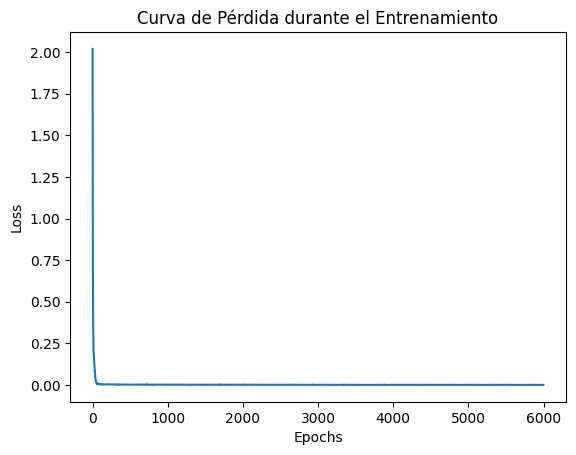

In [ ]:
# Graficar la curva de pérdida durante el entrenamiento
plt.plot(train_losses)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Curva de Pérdida durante el Entrenamiento')
plt.show()


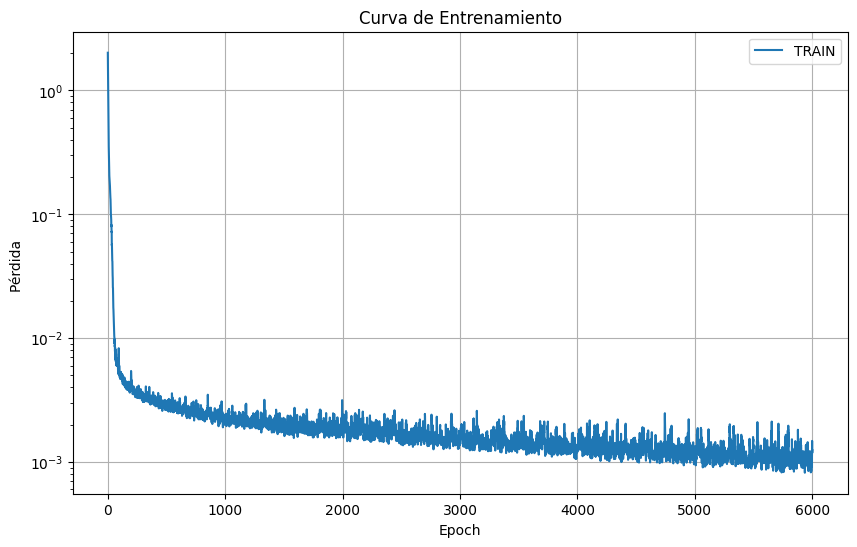

In [ ]:
# Error_magnitudes

plt.figure(figsize=(10, 6))
plt.semilogy(range(1, num_epochs + 1), train_losses, label='TRAIN')
plt.xlabel('Epoch')
plt.ylabel('Pérdida ')
plt.title('Curva de Entrenamiento')
plt.legend()
plt.grid(True)
plt.show()

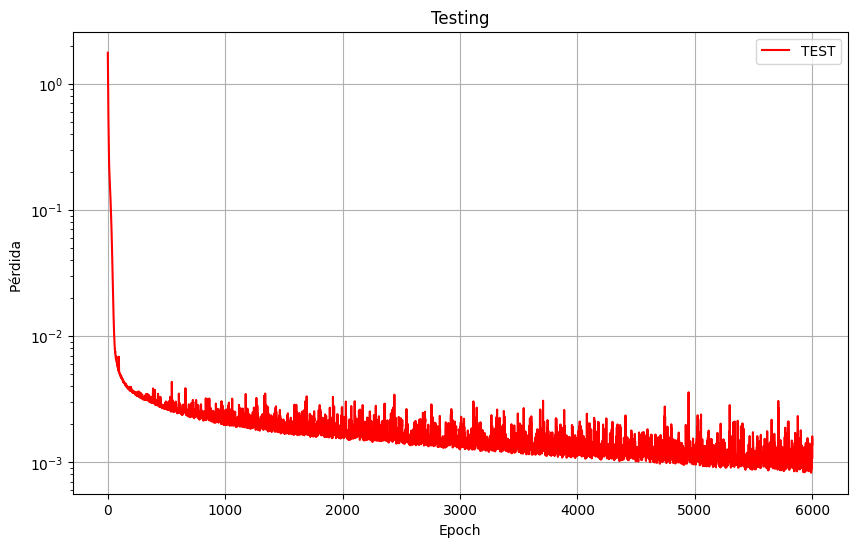

In [ ]:
plt.figure(figsize=(10, 6))
plt.semilogy(range(1, num_epochs + 1), test_losses, label='TEST', c = "r")
plt.xlabel('Epoch')
plt.ylabel('Pérdida ')
plt.title('Testing')
plt.legend()
plt.grid(True)
plt.show()

Evaluación del modelo:

 Usar datos de prueba para medir su rendimiento. Calcular las predicciones y compararlas con las etiquetas reales

In [ ]:
# Función para calcular los errores entre las predicciones y valores reales
def calcular_errores(predicted_outputs, expected_outputs):
    errors = predicted_outputs - expected_outputs
    error_magnitudes = torch.norm(errors, dim=1)
    return errors, error_magnitudes



In [ ]:
# Evaluación del modelo
model.eval()
test_inputs = test_tensor[:, :3]
expected_outputs = test_tensor[:, 3:]

with torch.no_grad():
    predicted_outputs = model(test_inputs)

errors, error_magnitudes = calcular_errores(predicted_outputs, expected_outputs)

print(expected_outputs.size())

torch.Size([60, 2])


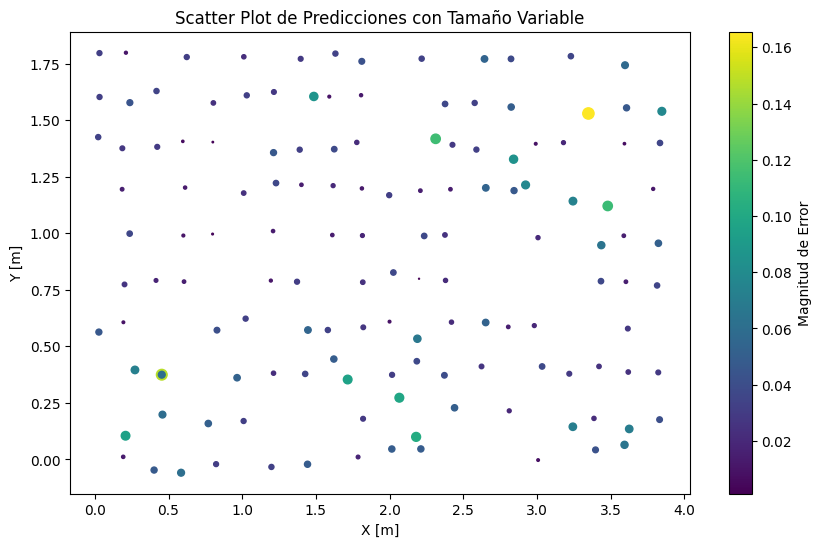

In [ ]:
# Visualización de dispersión con tamaño variable
plt.figure(figsize=(10, 6))
plt.scatter(predicted_outputs[:, 0], predicted_outputs[:, 1], c=error_magnitudes, cmap='viridis', s=error_magnitudes*400)
plt.colorbar(label='Magnitud de Error')
plt.xlabel("X [m]")
plt.ylabel("Y [m]")
plt.title("Scatter Plot de Predicciones con Tamaño Variable")
plt.show()

In [ ]:
def calcular_errores_clasico(resultados_clasico, coordenadas_reales, test_indices):
    errores_clasico = []  # Lista para almacenar los errores

    # Leer el contenido del archivo resultados_clasico.txt
    with open(resultados_clasico, "r") as file1:
      lines1 = file1.readlines()

    # Leer el contenido del archivo coordenadas_reales.txt
    with open(coordenadas_reales, "r") as file2:
      lines2 = file2.readlines()

    errores_clasico = np.zeros((len(test_indices), 2))

    for i, index in enumerate(test_indices):
        line1 = lines1[index + 1]  # +1 para omitir el encabezado
        line2 = lines2[index + 1]  # +1 para omitir el encabezado

        parts1 = line1.strip().split('|')
        parts2 = line2.strip().split('|')

        X_real = float(parts2[1])  # Coordenada X real
        Y_real = float(parts2[2])  # Coordenada Y real

        X_calculado = float(parts1[4])  # Coordenada X calculada por trilateración
        Y_calculado = float(parts1[5])  # Coordenada Y calculada por trilateración

        # Almacenar las diferencias en el array
        errores_clasico[i, 0] = X_real - X_calculado
        errores_clasico[i, 1] = Y_real - Y_calculado

    return errores_clasico


In [ ]:
# Llamar a la función para calcular los errores y almacenarlos en la lista
resultados_clasico = "generar_resultados_clasico.txt"
coordenadas_reales = "coordenadas_cuadriculas.txt"

errores_clasico = calcular_errores_clasico(resultados_clasico, coordenadas_reales, test_indices)
error_magnitudes_clasico = np.linalg.norm(errores_clasico, axis = 1)


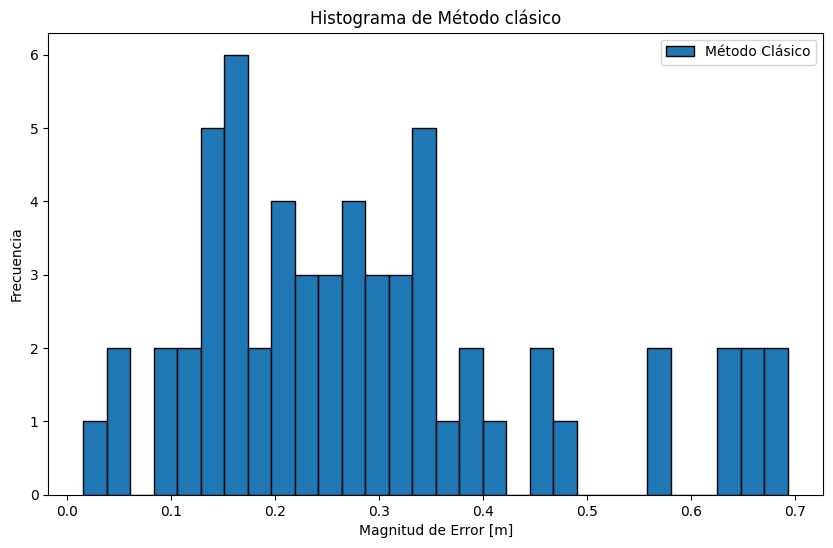

In [ ]:
# Crear el Histograma de Errores para el método clásico

plt.figure(figsize=(10, 6))
plt.hist(error_magnitudes_clasico, bins=30, edgecolor='black', alpha=1, label='Método Clásico')
plt.xlabel("Magnitud de Error [m]")
plt.ylabel("Frecuencia")
plt.title("Histograma de Método clásico")
plt.legend()
plt.show()


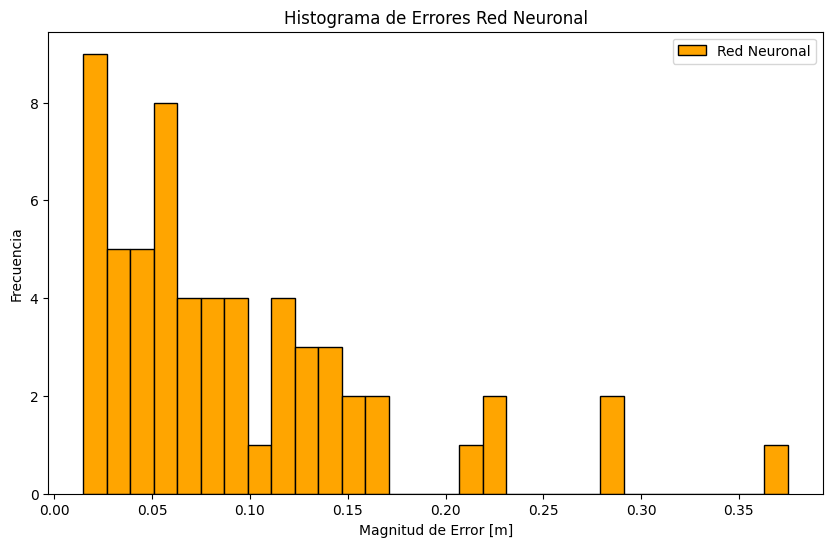

In [ ]:
# Crear el Histograma de Errores
plt.figure(figsize=(10, 6))
plt.hist(error_magnitudes, bins=30, edgecolor='black', alpha=1, color= 'orange', label='Red Neuronal')
plt.xlabel("Magnitud de Error [m]")
plt.ylabel("Frecuencia")
plt.title("Histograma de Errores Red Neuronal")
plt.legend()
plt.show()

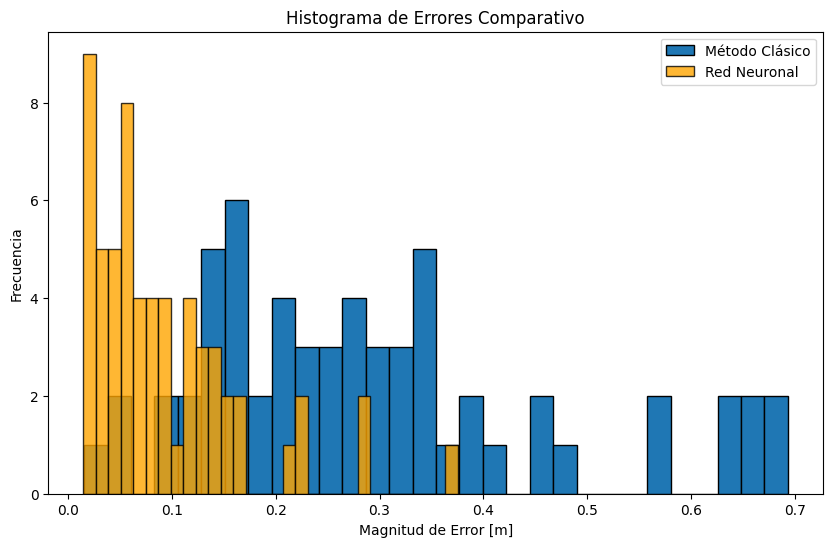

In [ ]:
# Generar el Histograma Comparativo
plt.figure(figsize=(10, 6))
plt.hist(error_magnitudes_clasico, bins=30, edgecolor='black', alpha=1, label='Método Clásico')
plt.hist(error_magnitudes, bins= 30, edgecolor='black', alpha=0.8, color= 'orange',label='Red Neuronal')
plt.xlabel("Magnitud de Error [m]")
plt.ylabel("Frecuencia")
plt.title("Histograma de Errores Comparativo")
plt.legend()
plt.show()

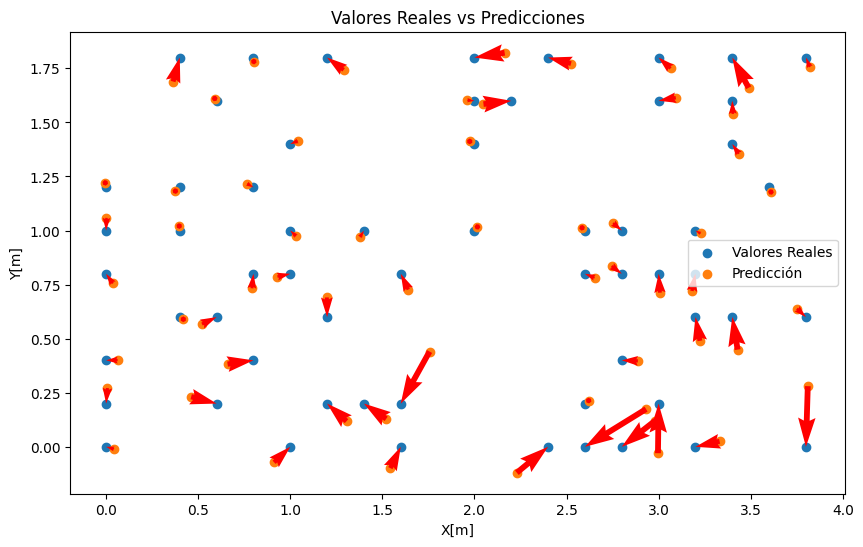

In [ ]:
plt.figure(figsize=(10, 6))
plt.scatter(expected_outputs[:, 0], expected_outputs[:, 1], label="Valores Reales")
plt.scatter(predicted_outputs[:, 0], predicted_outputs[:, 1], label="Predicción")

# Calcula los errores inversos para que las flechas se dirijan desde la predicción al valor real
inverted_errors = expected_outputs - predicted_outputs

plt.quiver(predicted_outputs[:, 0], predicted_outputs[:, 1],
           inverted_errors[:, 0], inverted_errors[:, 1],
           angles='xy', scale_units='xy', scale=1, color='r')

plt.xlabel("X[m]")
plt.ylabel("Y[m]")
plt.title("Valores Reales vs Predicciones")
plt.legend()
plt.show()


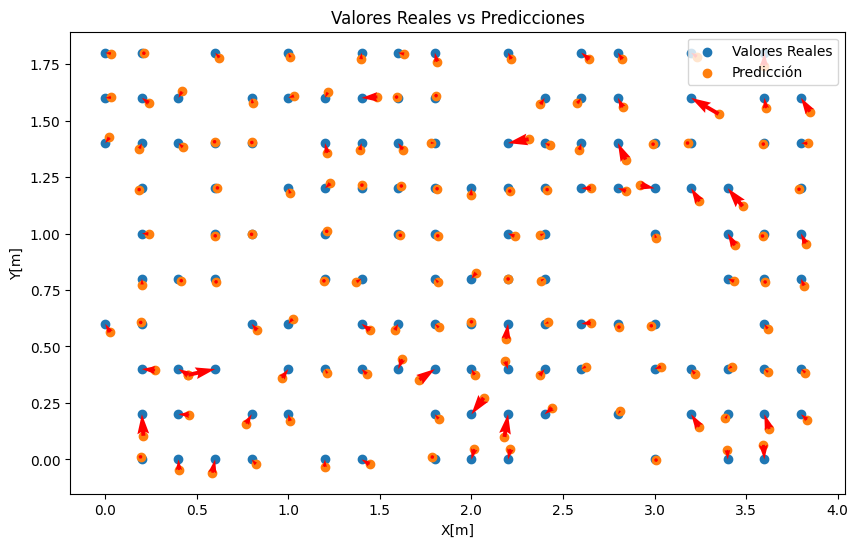

In [ ]:
model.eval()
train_inputs = train_tensor[:, :3]
expected_outputs = train_tensor[:, 3:]

with torch.no_grad():
    predicted_outputs = model(train_inputs)

errors, error_magnitudes = calcular_errores(predicted_outputs, expected_outputs)

plt.figure(figsize=(10, 6))
plt.scatter(expected_outputs[:, 0], expected_outputs[:, 1], label="Valores Reales")
plt.scatter(predicted_outputs[:, 0], predicted_outputs[:, 1], label="Predicción")

inverted_errors = expected_outputs - predicted_outputs

plt.quiver(predicted_outputs[:, 0], predicted_outputs[:, 1],
           inverted_errors[:, 0], inverted_errors[:, 1],
           angles='xy', scale_units='xy', scale=1, color='r')

plt.xlabel("X[m]")
plt.ylabel("Y[m]")
plt.title("Valores Reales vs Predicciones")
plt.legend()
plt.show()

Visualización de resultados (Matplotlib)

In [ ]:
# Calcular el error promedio y la desviación estándar para el método clásico
error_promedio_clasico = np.mean(error_magnitudes_clasico)
desviacion_estandar_clasico = np.std(error_magnitudes_clasico)


# Calcular el error promedio y la desviación estándar para la red neuronal
error_promedio_red_neuronal = np.mean(error_magnitudes.numpy())
desviacion_estandar_red_neuronal = np.std(error_magnitudes.numpy())

# Crear una tabla de comparación
al_cuadrado = "\u00b2"
tabla_comparacion = [
    ["Método", f"Media [m]", "Desviación Estándar [m]"],
    ["Clásico", error_promedio_clasico, desviacion_estandar_clasico],
    ["Red Neuronal", error_promedio_red_neuronal, desviacion_estandar_red_neuronal]
]

# Imprimir la tabla con recuadro
tabla_formateada = tabulate(tabla_comparacion, headers='firstrow', tablefmt='fancy_grid')
print(tabla_formateada)


╒══════════════╤═════════════╤═══════════════════════════╕
│ Método       │   Media [m] │   Desviación Estándar [m] │
╞══════════════╪═════════════╪═══════════════════════════╡
│ Clásico      │   0.292289  │                  0.169925 │
├──────────────┼─────────────┼───────────────────────────┤
│ Red Neuronal │   0.0380808 │                  0.026885 │
╘══════════════╧═════════════╧═══════════════════════════╛


In [ ]:
# MSE y MAE

# Calcula el error cuadrático medio (MSE)
mse = torch.mean(torch.square(errors))
# Calcular el error absoluto promedio (MAE)
mae = torch.mean(torch.abs(errors))
# Almacenar los errores en la lista
errores_red_neuronal = error_magnitudes.tolist()
# Calcula el error cuadrático medio (MSE)
mse_clasico = np.mean(np.square(errores_clasico))
# Calcular el error absoluto promedio (MAE)
mae_clasico = np.mean(np.abs(errores_clasico))


mse_red = mse.item()
mae_red = mae.item() #DISPERSIÓN

# Crear una tabla de comparación
al_cuadrado = "\u00b2"
tabla_comparacion = [
    ["Método", f"MSE [m{al_cuadrado}]", "MAE [m]"],
    ["Clásico", mse_clasico, mae_clasico],
    ["Red Neuronal", mse_red, mae_red]
]

# Imprimir la tabla con recuadro
tabla_formateada = tabulate(tabla_comparacion, headers='firstrow', tablefmt='fancy_grid')
print(tabla_formateada)


╒══════════════╤════════════╤═══════════╕
│ Método       │   MSE [m²] │   MAE [m] │
╞══════════════╪════════════╪═══════════╡
│ Clásico      │ 0.0571538  │ 0.183533  │
├──────────────┼────────────┼───────────┤
│ Red Neuronal │ 0.00108647 │ 0.0243261 │
╘══════════════╧════════════╧═══════════╛


Relación entre las distancias a los nodos usando el mediciones directas y las obtenidas con los UWB (mediante tiempo de vuelo)

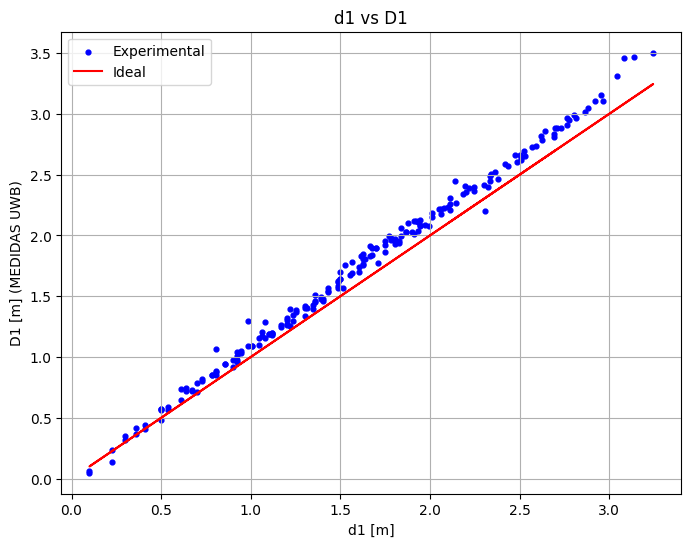

In [ ]:
data_file_promedios = "datos_promedios.txt"
data_file_distancias = "distancias_clasico.txt"

data_promedios = np.loadtxt(data_file_promedios, delimiter='|', skiprows=1, usecols=(1,))
data_distancias = np.loadtxt(data_file_distancias, delimiter='|', skiprows=1, usecols=(1,))

plt.figure(figsize=(8, 6))
plt.scatter(data_distancias, data_promedios, label="Experimental", color = "b", s = 12)
plt.plot(data_distancias, data_distancias, color='red', linestyle='-', label="Ideal")
plt.xlabel("d1 [m]")
plt.ylabel("D1 [m] (MEDIDAS UWB)")
plt.title("d1 vs D1")
plt.legend()
plt.grid(True)
plt.show()


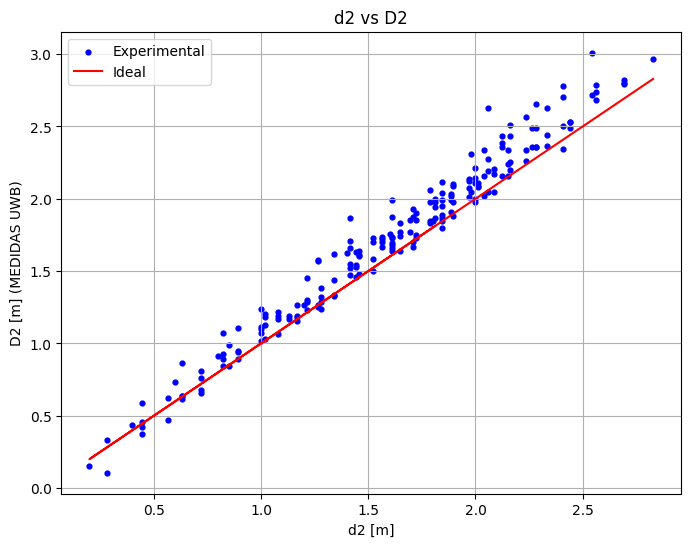

In [ ]:
data_promedios = np.loadtxt(data_file_promedios, delimiter='|', skiprows=1, usecols=(2,))
data_distancias = np.loadtxt(data_file_distancias, delimiter='|', skiprows=1, usecols=(2,))

plt.figure(figsize=(8, 6))
plt.scatter(data_distancias, data_promedios, label="Experimental", color = "b", s = 12)
plt.plot(data_distancias, data_distancias, color='red', linestyle='-', label="Ideal")
plt.xlabel("d2 [m]")
plt.ylabel("D2 [m] (MEDIDAS UWB)")
plt.title("d2 vs D2")
plt.legend()
plt.grid(True)
plt.show()


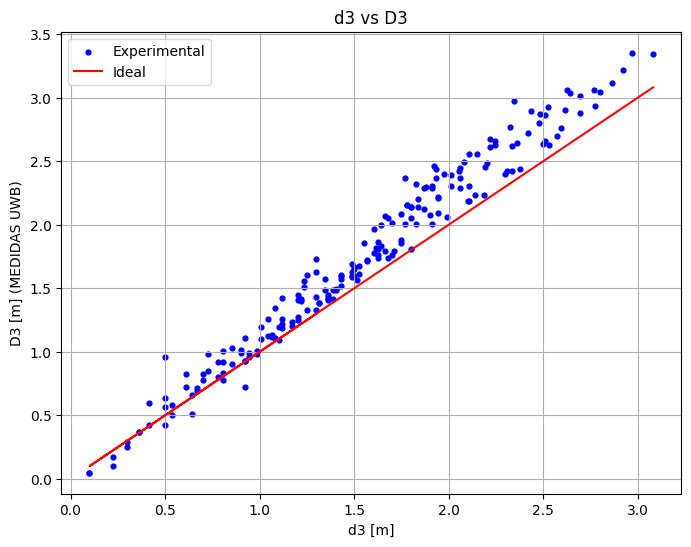

In [ ]:
data_promedios = np.loadtxt(data_file_promedios, delimiter='|', skiprows=1, usecols=(3,))
data_distancias = np.loadtxt(data_file_distancias, delimiter='|', skiprows=1, usecols=(3,))

plt.figure(figsize=(8, 6))
plt.scatter(data_distancias, data_promedios, label="Experimental", color = "b", s = 12)
plt.plot(data_distancias, data_distancias, color='red', linestyle='-', label="Ideal")
plt.xlabel("d3 [m]")
plt.ylabel("D3 [m] (MEDIDAS UWB)")
plt.title("d3 vs D3")
plt.legend()
plt.grid(True)
plt.show()
